# Summarize performance of classifiers
Required inputs:
* `svm_dataset_performance_metrics.txt`
* `cnn_dataset_performance_metrics.txt`

Additional inputs:
* `test_set.mat` and `test_retinopathy.mat` are used to calculate the chance lines.
* `selene_sdk.train_model.{train,validation}.txt` are training histories output by Selene. There is one file for each fold of each training batch.

Outputs:
* `modelPerformanceComparison_{micro,weighted,macro,Si,In,WE,SE,SiVsSE_Round3and4}.svg`: Various performance summaries of the classifiers over multiple rounds of active learning.
* `samplingComparison.svg`: Performance of the classifiers when trained with Round 3 or random sampling.
* `mutagenesisComparison.svg`: Performance of the SVM when trained with Round 1 and 2, or Round 1 and 37% of Round 3.
* `cnnClfLossCurveSummary.svg`: Training history of the CNN classifier for various rounds of learning.

In [1]:
import os
import sys

import numpy as np
from scipy import stats
import scipy.io as scio
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from IPython.display import display

from src.mpra_tools import loaders, plot_utils

figures_dir = "Figures"

plot_utils.set_manuscript_params()

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


Load in data and aggregate together.

In [2]:
svm_dir = os.path.join(
    "ModelFitting",
    "SVM",
)
svm_df = loaders.load_data(
    os.path.join(svm_dir, "svm_dataset_performance_metrics.txt"),
)

cnn_dir = os.path.join(
    "ModelFitting",
    "CNN_Clf",
)
cnn_df = loaders.load_data(
    os.path.join(cnn_dir, "cnn_dataset_performance_metrics.txt"),
)
# Get rid of CNN Round 1, not enough data to fit
cnn_df = cnn_df.drop(index="Round1")

# Join together, then average across folds for each training data x model x test set
svm_df["model"] = "SVM"
cnn_df["model"] = "CNN"
model_df = pd.concat([svm_df, cnn_df]).replace({
    "test_set": "Mutagenesis",
    "test_retinopathy": "Genomic",
})

model_grouper = model_df.groupby(["dataset", "model", "test_set"])
model_summary_df = model_grouper[[
    "nseqs_train", "micro", "weighted", "macro", "Si", "In", "WE", "SE"
]].agg(["mean", "std"])

model_summary_df

nseqs_train               micro            \
                                         mean       std      mean       std   
dataset         model test_set                                                
Round1          SVM   Mutagenesis      8427.9  0.316228  0.299437  0.011961   
Round2          CNN   Genomic         11823.0  0.000000  0.488915  0.018563   
                      Mutagenesis     11823.0  0.000000  0.354430  0.002297   
                SVM   Mutagenesis     12288.0  0.000000  0.293249  0.007508   
Round3a         CNN   Genomic         16199.2  0.421637  0.271445  0.011445   
                      Mutagenesis     16199.2  0.421637  0.468636  0.012489   
                SVM   Mutagenesis     16664.2  0.421637  0.359775  0.014808   
Round3aNoRound2 CNN   Genomic         12379.2  0.421637  0.256123  0.008033   
                      Mutagenesis     12379.2  0.421637  0.465260  0.018751   
                SVM   Mutagenesis     12844.2  0.421637  0.373418  0.010017   
Round3b         CNN   Genomic         23416.4  0.516398  0.295647  0.021828   
                      Mutagenesis     23416.4  0.516398  0.502672  0.018849   
                SVM   Mutagenesis     23881.4  0.516398  0.448242  0.008995   
Round3c         CNN   Genomic         17906.5  0.527046  0.237551  0.019493   
                      Mutagenesis     17906.5  0.527046  0.378340  0.015478   
                SVM   Mutagenesis     18234.7  0.483046  0.310970  0.005323   
Round4a         CNN   Genomic         77852.2  0.421637  0.530528  0.008671   
                      Mutagenesis     77852.2  0.421637  0.318987  0.004487   
                SVM   Mutagenesis     78314.5  0.527046  0.379044  0.013959   
Round4b         CNN   Genomic         34221.1  0.316228  0.368601  0.015034   
                      Mutagenesis     34221.1  0.316228  0.509986  0.014514   
                SVM   Mutagenesis     34686.1  0.316228  0.463572  0.008418   

                                   weighted               macro            \
                                       mean       std      mean       std   
dataset         model test_set                                              
Round1          SVM   Mutagenesis  0.251012  0.012890  0.234238  0.020868   
Round2          CNN   Genomic      0.334429  0.002851  0.175154  0.008809   
                      Mutagenesis  0.192052  0.009799  0.135783  0.007978   
                SVM   Mutagenesis  0.259535  0.011555  0.228952  0.018087   
Round3a         CNN   Genomic      0.283538  0.013659  0.245573  0.008528   
                      Mutagenesis  0.470069  0.013327  0.368145  0.017028   
                SVM   Mutagenesis  0.360741  0.018477  0.291596  0.021642   
Round3aNoRound2 CNN   Genomic      0.245847  0.009302  0.211732  0.006051   
                      Mutagenesis  0.460922  0.019904  0.339630  0.022485   
                SVM   Mutagenesis  0.360661  0.012440  0.316532  0.014802   
Round3b         CNN   Genomic      0.309303  0.023839  0.275248  0.015075   
                      Mutagenesis  0.510087  0.019297  0.409390  0.021082   
                SVM   Mutagenesis  0.457911  0.011509  0.350786  0.013894   
Round3c         CNN   Genomic      0.232048  0.029116  0.214732  0.022323   
                      Mutagenesis  0.377329  0.016545  0.329011  0.026325   
                SVM   Mutagenesis  0.291163  0.005809  0.246570  0.011649   
Round4a         CNN   Genomic      0.480398  0.006167  0.309050  0.005909   
                      Mutagenesis  0.195771  0.005941  0.155098  0.005397   
                SVM   Mutagenesis  0.400591  0.015058  0.307953  0.012782   
Round4b         CNN   Genomic      0.395257  0.014156  0.338547  0.012332   
                      Mutagenesis  0.510664  0.012841  0.383261  0.014738   
                SVM   Mutagenesis  0.470830  0.009274  0.350795  0.012492   

                                         Si                  In            \
                                       mean       std  

Load in the test sets to create a confusion matrix for random guessing.

In [3]:
test_set_files = {
    "Mutagenesis": "test_set",
    "Genomic": "test_retinopathy",
}
chance_confusion = {}
for name, f in test_set_files.items():
    labels = scio.loadmat(os.path.join(cnn_dir, f + ".mat"))["activity_bin"].flatten()
    class_freq = pd.Series(labels).value_counts(normalize=True).sort_index()
    print(f"Class frequency for {name} data:")
    print(class_freq)
    confusion = np.outer(class_freq, [0.25, 0.25, 0.25, 0.25])
    chance_confusion[name] = confusion

Class frequency for Mutagenesis data:
0    0.036568
1    0.168776
2    0.354430
3    0.440225
dtype: float64
Class frequency for Genomic data:
0    0.280905
1    0.112594
2    0.500290
3    0.106210
dtype: float64


Helper functions for getting chance performance metrics.

In [4]:
def get_class_f1(confusion, i):
    tp = confusion[i, i]
    recall = tp / confusion[i].sum()
    precision = tp / confusion[:, i].sum()
    return 2 * (precision * recall) / (precision + recall)

def get_chance_f1(confusion, averaging):
    assert averaging == "micro" or averaging == "weighted" or averaging == "macro"
    if averaging == "micro":
        return np.diag(confusion).sum()
    else:
        classwise = [get_class_f1(confusion, i) for i in range(len(confusion))]
        if averaging == "weighted":
            return np.average(classwise, weights=confusion.sum(axis=1))
        else:
            return np.average(classwise)

Barplot of the iterative performance summary.

In [5]:
vermillion = (213/255, 94/255, 0)
blue = (0, 114/255, 178/255)
bluish_green = (0, 158/255, 115/255)
reddish_purple = (204/255, 121/255, 167/255)
sky_blue = (86/255, 180/255, 233/255)
carbon_gray = (98/255, 93/255, 93/255)
arsenic = (59/255, 68/255, 75/255)
charcoal = (54/255, 69/255, 79/255)
deep_space_sparkle = (74/255, 100/255, 108/255)
dim_gray = (105/255, 105/255, 105/255)
gray = (128/255, 128/255, 128/255)
light_gray = (211/255, 211/255, 211/255)
medium_gray= (190/255, 190/255, 190/255)
nickel = (114/255, 116/255, 114/255)

Chance for the micro F1 on Mutagenesis is 0.25
Chance for the micro F1 on Mutagenesis is 0.25
Chance for the micro F1 on Genomic is 0.25
Chance for the weighted F1 on Mutagenesis is 0.28064790583134225
Chance for the weighted F1 on Mutagenesis is 0.28064790583134225
Chance for the weighted F1 on Genomic is 0.27442586002637515
Chance for the macro F1 on Mutagenesis is 0.2193520941686578
Chance for the macro F1 on Mutagenesis is 0.2193520941686578
Chance for the macro F1 on Genomic is 0.2255741399736248
Chance for the Si F1 on Mutagenesis is 0.0638036809815951
Chance for the Si F1 on Mutagenesis is 0.0638036809815951
Chance for the Si F1 on Genomic is 0.264553156600164
Chance for the In F1 on Mutagenesis is 0.20151133501259447
Chance for the In F1 on Mutagenesis is 0.20151133501259447
Chance for the In F1 on Genomic is 0.15526210484193678
Chance for the WE F1 on Mutagenesis is 0.2931937172774869
Chance for the WE F1 on Mutagenesis is 0.2931937172774869
Chance for the WE F1 on Genomic is 

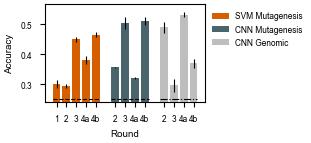

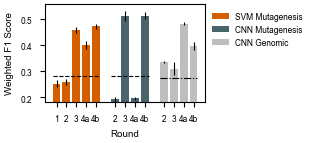

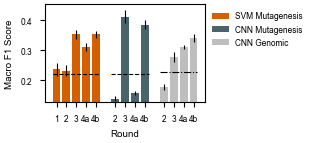

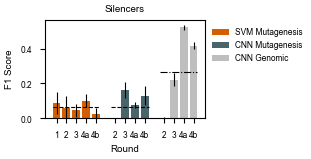

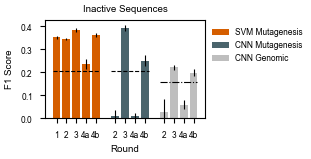

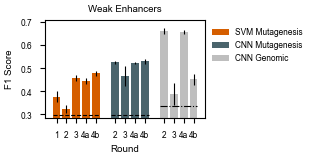

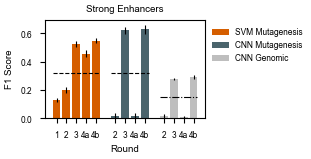

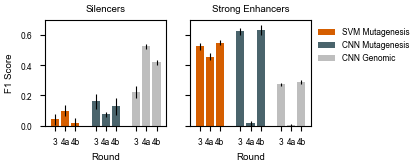

In [6]:
svm_color = vermillion
cnn_mut_color = deep_space_sparkle
cnn_gen_color = medium_gray

class_short_to_long = {
    "Si": "Silencers",
    "In": "Inactive Sequences",
    "WE": "Weak Enhancers",
    "SE": "Strong Enhancers",
}

# Helper function to make the plot, given the metric name and a handle to the function to get the chance line
def make_performance_barplot(df, metric, compare_dict, chance_handle=None, fig_frac=0.5, aspect=0.618, figax=None):
    if figax:
        fig, ax = figax
    else:
        fig, ax = plt.subplots(figsize=plot_utils.get_figsize(frac=fig_frac, aspect=aspect))
        
    grouper = df[metric].groupby(["model", "test_set"], sort=False)
    
    min_y = 1
    last = -2
    xticks = np.array([])
    xticklabels = []
    
    for i, (model, test_set) in enumerate(model_display_order):
        data = grouper.get_group((model, test_set))
        xaxis = last + 2 + np.arange(len(data))
        xticks = np.append(xticks, xaxis)
        xticklabels += [main_display_comparison[i] for i in data.index.get_level_values("dataset").values]
        
        ax.bar(
            xaxis,
            data["mean"],
            yerr=data["std"],
            color=colors[i],
            label=model + " " + test_set
        )
        
        # Show a chance line for the two different datasets
        if chance_handle:
            if test_set == "Mutagenesis":
                ls = "--"
            else:
                ls = "-."

            chance = chance_handle(chance_confusion[test_set])
            print(f"Chance for the {metric} F1 on {test_set} is {chance}")
            min_y = min(min_y, chance)
            ax.plot([xaxis[0] - 0.4, xaxis[-1] + 0.4], [chance, chance], color="k", linestyle=ls)

        last = xaxis[-1]
        min_y = min(min_y, data["mean"].min())

    ax.set_xticks(xticks, xticklabels)
    ax.set_xlabel("Round")

    # Lowest the ylim can be is zero
    min_y = max(min_y - 0.01, 0)
    
    return fig, ax, min_y
    
main_display_comparison = {
    "Round1": "1",
    "Round2": "2",
    "Round3b": "3",
    "Round4a": "4a",
    "Round4b": "4b",
}
model_display_order = [
    ("SVM", "Mutagenesis"),
    ("CNN", "Mutagenesis"),
    ("CNN", "Genomic"),
]
width = 0.25
colors = [
    svm_color,
    cnn_mut_color,
    cnn_gen_color,
]

model_summary_main_display_df = model_summary_df.loc[
    main_display_comparison.keys()]

weighted_min_y = 0
for metric in ["micro", "weighted", "macro"]:
    fig, ax, min_y = make_performance_barplot(
        model_summary_main_display_df,
        metric,
        main_display_comparison,
        chance_handle=lambda x: get_chance_f1(x, metric),
        fig_frac=0.3,
        # aspect=0.4,
    )
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
        frameon=False,
    )
    ax.set_ylim(bottom=min_y)
    if metric == "micro":
        ax.set_ylabel("Accuracy")
    else:
        ax.set_ylabel(metric.capitalize() + " F1 Score")
        
    if metric == "weighted":
        weighted_min_y = min_y

    plot_utils.save_fig(fig, os.path.join(figures_dir, f"modelPerformanceComparison_{metric}"))
    
for i, metric in enumerate(["Si", "In", "WE", "SE"]):
    fig, ax, min_y = make_performance_barplot(
        model_summary_main_display_df,
        metric,
        main_display_comparison,
        chance_handle=lambda x: get_class_f1(x, i),
        fig_frac=0.3,
        # aspect=0.4,
    )
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
        frameon=False,
    )
    ax.set_ylabel("F1 Score")
    ax.set_ylim(bottom=min_y)
    ax.set_title(class_short_to_long[metric])
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"modelPerformanceComparison_{metric}"))
    
# Ok now let's make the Si and SE panels again, but only focus on Rounds 3 and 4, and have the yaxis shared
fig, ax_list = plt.subplots(ncols=2, sharey=True, figsize=plot_utils.get_figsize(frac=0.5, aspect=0.4))
ymax = 0
for ax, metric in zip(ax_list, ["Si", "SE"]):
    make_performance_barplot(
        model_summary_main_display_df.loc[["Round3b", "Round4a", "Round4b"]],
        metric,
        main_display_comparison,
        figax=(fig, ax)
    )
    ax.set_title(class_short_to_long[metric])
    ymax = max(ymax, ax.get_ylim()[1])

for ax in ax_list:
    ax.set_ylim(0, ymax)
    
ax_list[0].set_ylabel("F1 Score")
ax_list[1].legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False
)
plot_utils.save_fig(fig, os.path.join(figures_dir, "modelPerformanceComparison_SiVsSE_Round3and4"))

Barplots comparing uncertainty sampling to random sampling.

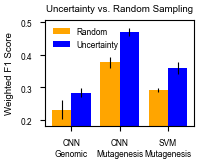

In [7]:
active_vs_random_df = model_summary_df.loc[["Round3a", "Round3c"]].rename(index={
    "Round3a": "Uncertainty",
    "Round3c": "Random",
})
dataset_to_color = {
    "Uncertainty": "blue",
    "Random": "orange",
}

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(frac=0.28, aspect=0.72))
x = np.array([0, 1, 2])
width = 0.4
for i, (dataset, df) in enumerate(active_vs_random_df.groupby("dataset")):
    offset = width * i
    ax.bar(
        x + offset,
        df["weighted", "mean"],
        width,
        yerr=df["weighted", "std"],
        label=dataset,
        color=dataset_to_color[dataset],
    )
    
ticklabels = df.index.get_level_values(level="model") + "\n" +\
    df.index.get_level_values(level="test_set")

ax.set_xticks(x + width / 2, ticklabels)
ax.set_ylabel("Weighted F1 Score")
ax.legend(frameon=False, loc="upper left")
ax.set_title("Uncertainty vs. Random Sampling")
ax.set_ylim(bottom=weighted_min_y)
plot_utils.save_fig(fig, os.path.join(figures_dir, "samplingComparison"))

Bar plot comparing 1+2 vs 1+3, using the SVM only.

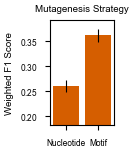

In [8]:
perturbation_comparison_df = model_summary_df.loc[(["Round2", "Round3aNoRound2"], "SVM", "Mutagenesis")]
perturbation_comparison_df = perturbation_comparison_df.rename(index={
    "Round2": "Nucleotide",
    "Round3aNoRound2": "Motif"
}).droplevel(["model", "test_set"])
fig, ax = plt.subplots(figsize=plot_utils.get_figsize(frac=0.12, aspect=1.67))
ax.bar(
    np.arange(len(perturbation_comparison_df)),
    perturbation_comparison_df["weighted", "mean"],
    yerr=perturbation_comparison_df["weighted", "std"],
    tick_label=perturbation_comparison_df.index,
    color=svm_color,
)
ax.set_yticks(np.arange(0.2, ax.get_ylim()[1], 0.05))
ax.set_ylabel("Weighted F1 Score")
ax.set_title("Mutagenesis Strategy")
ax.set_ylim(bottom=weighted_min_y)
plot_utils.save_fig(fig, os.path.join(figures_dir, "mutagenesisComparison"))

Show CNN training history.

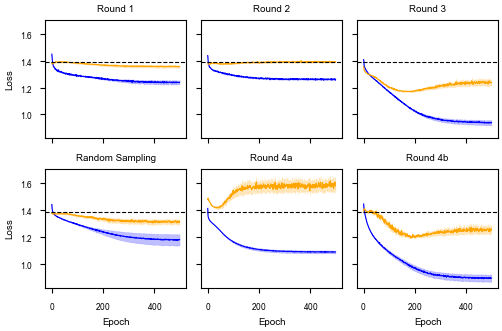

In [9]:
display_groups = {
    "Round1": "Round 1",
    "Round2": "Round 2",
    "Round3b": "Round 3",
    "Round3c": "Random Sampling",
    "Round4a": "Round 4a",
    "Round4b": "Round 4b"
}

dataset_train_loss = dict()
dataset_val_loss = dict()
for dataset in  display_groups:
    if os.path.exists(os.path.join(cnn_dir, dataset)):
        train_loss = dict()
        val_loss = dict()
        
        for fold in range(10):
            train_loss[fold] = loaders.load_data(os.path.join(cnn_dir, dataset, str(fold + 1), "selene_sdk.train_model.train.txt"), index_col=None).squeeze()
            val_metrics = loaders.load_data(os.path.join(cnn_dir, dataset, str(fold + 1), "selene_sdk.train_model.validation.txt"), index_col=None)
            val_loss[fold] = val_metrics["loss"]
            
        train_loss = pd.DataFrame(train_loss).agg(["mean", "std"], axis=1)
        val_loss = pd.DataFrame(val_loss).agg(["mean", "std"], axis=1)                    
        dataset_train_loss[dataset] = train_loss
        dataset_val_loss[dataset] = val_loss

dataset_train_loss = pd.concat(dataset_train_loss, axis=1)
dataset_val_loss = pd.concat(dataset_val_loss, axis=1)
chance = -np.log(0.25)

ngroups = len(display_groups)
ncols = 3
nrows = int(np.ceil(ngroups / ncols))
fig, ax_list = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharex=True,
    sharey=True,
    figsize=plot_utils.get_figsize(0.75, aspect=2/3),
)

for ax, dataset in zip(ax_list.flatten(), display_groups.keys()):
    ax.plot(
        dataset_train_loss[(dataset, "mean")],
        color="blue",
    )
    ax.fill_between(
        dataset_train_loss.index,
        dataset_train_loss[(dataset, "mean")] - dataset_train_loss[(dataset, "std")],
        dataset_train_loss[(dataset, "mean")] + dataset_train_loss[(dataset, "std")],
        color="blue",
        alpha=0.25,
    )
    ax.plot(
        dataset_val_loss[(dataset, "mean")],
        color="orange"
    )
    ax.fill_between(
        dataset_val_loss.index,
        dataset_val_loss[(dataset, "mean")] - dataset_val_loss[(dataset, "std")],
        dataset_val_loss[(dataset, "mean")] + dataset_val_loss[(dataset, "std")],
        color="orange",
        alpha=0.25,
    )
    ax.set_title(display_groups[dataset])
    ax.axhline(
        chance,
        color="k",
        linestyle="--",
    )
    
# Get rid of unused subplots, and add x labels
for i in range(ax_list.size - 1, len(display_groups) - ncols - 1, -1):
    coords = np.unravel_index(i, ax_list.shape)
    ax = ax_list[coords]
    if i >= len(display_groups):
        ax.remove()
        ax_list[coords] = None
    else:
        ax.set_xlabel("Epoch")
    
for row in range(nrows):
    ax_list[row, 0].set_ylabel("Loss")

fig.tight_layout()

plot_utils.save_fig(fig, os.path.join(figures_dir, "cnnClfLossCurveSummary"))